In [2]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import cosmoplots

from fppanalysis.running_moments import window_radius, run_norm_ds

from analysis_functions.constants import greenwald_fraction, shot_time_window
from analysis_functions.apd_functions import get_signal, get_time, get_rz, get_rz_full

from velocity_estimation import two_dim_velocity_estimates as tdve
from velocity_estimation import utils as u
from  velocity_estimation import time_delay_estimation as td

### This code plots time delay estimation (TDE) vector plots

In [28]:
cross_correlation_method = False

if cross_correlation_method:

    #-------------- Cross correlation ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CC

    use_3point_method = True
    ccf_min_lag = 1
    minimum_cc_value = 0
    running_mean = True

    eo.use_3point_method = True if use_3point_method == True else False
    eo.cc_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.cc_options.minimum_cc_value = minimum_cc_value

else:
        
    #-------------- Cross conditional average ----------------#

    eo = tdve.EstimationOptions()
    eo.method = td.TDEMethod.CA

    use_3point_method = True
    ccf_min_lag = 1
    running_mean = True
    plot_events = False
    ca_min = 2.5
    ca_max = np.inf

    eo.use_3point_method = True if use_3point_method == True else False
    eo.ca_options.running_mean = True if running_mean == True else False

    eo.neighbour_options = tdve.NeighbourOptions(ccf_min_lag=ccf_min_lag, max_separation=1, min_separation=1)

    eo.ca_options.delta = 1.4e-4
    eo.ca_options.window = True
    eo.ca_options.min_threshold = ca_min
    eo.ca_options.max_threshold = ca_max

In [24]:
shot = 1110201011
f_GW = greenwald_fraction[shot]
path = Path('/Users/ahe104/Box/mfe_data/raw_apd_data')
ds = xr.open_dataset(str(path) + '/' + f'apd_signal_array_{shot}.nc')
R_coordinates, Z_coordinates = get_rz_full(ds)

In [25]:
# Remove dead pixels
path_dead_pixel = Path('/Users/ahe104/Box/mfe_data/dead_pixels')
dead_pix = np.load(
    str(path_dead_pixel)
    + "/"
    + f"dead_pixels_shot_{shot}.npz"
)
dead_pix_arr = dead_pix['dead_pix_arr'] # Don't flip array, quiver plot is oriented this way
dead_pix_arr_ds = dead_pix_arr[::-1,:] # Flip array to match ds['frames'] orientation
for y in range(dead_pix_arr_ds.shape[0]):
    for x in range(dead_pix_arr_ds.shape[1]):
        if dead_pix_arr_ds[9-y, x]:
            ds['frames'].loc[dict(y=y, x=x)] = np.nan

In [26]:
# Slice and normalize data
t_start = shot_time_window[shot][0]
t_end = shot_time_window[shot][1]
sliced_ds = ds.sel(time=slice(t_start, t_end))
radius = window_radius(1e3, sliced_ds.time)
ds = run_norm_ds(sliced_ds, radius)

In [27]:
# Estimate velocities
movie_data = tdve.estimate_velocity_field(u.CModImagingDataInterface(ds), eo)
vx = movie_data.get_vx()
vy = movie_data.get_vy()
confidences = movie_data.get_confidences()
R = movie_data.get_R()
Z = movie_data.get_Z()
events = movie_data.get_events()

/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/two_dim_velocity_estimates.py:351: UserWarning: Pixel (6, 3) does not fulfill cross-correlation time lag condition with respect to pixel of (6, 2). Updating.
  warnings.warn(
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/two_dim_velocity_estimates.py:351: UserWarning: Pixel (6, 2) does not fulfill cross-correlation time lag condition with respect to pixel of (6, 3). Updating.
  warnings.warn(
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/two_dim_velocity_estimates.py:351: UserWarning: Pixel (0, 6) does not fulfill cross-correlation time lag condition with respect to pixel of (0, 5). Updating.
  warnings.warn(
/Users/ahe104/opt/anaconda3/envs/fpp/lib/python3.10/site-packages/velocity_estimation/two_dim_velocity_estimates.py:351: UserWarning: Pixel (0, 5) does not fulfill cross-correlation time lag condition with respect to 

In [29]:
# Mark dead and alive pixels
true_indices = np.where(dead_pix_arr)
false_indices = np.where(dead_pix_arr == False)

dead_pixels_R = R[true_indices]
dead_pixles_Z = Z[true_indices]
alive_pixels_R = R[false_indices]
alive_pixels_Z = Z[false_indices]

-1.0800000429153442


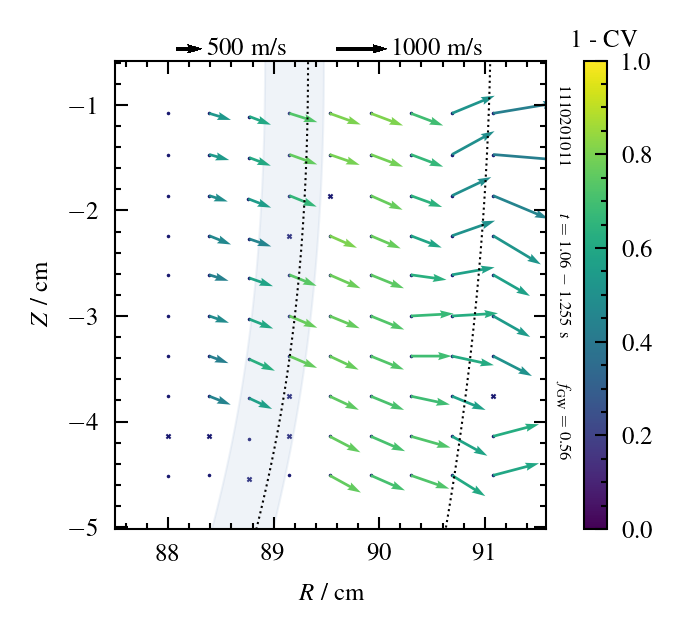

In [34]:
save = False

axes_size = cosmoplots.set_rcparams_dynamo(plt.rcParams, num_cols=1, ls="thin")
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["font.size"] = 6
plt.rcParams["axes.labelsize"] = 6
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["xtick.major.size"] = 3
plt.rcParams["xtick.minor.size"] = 1.5
plt.rcParams["ytick.major.size"] = 3
plt.rcParams["ytick.minor.size"] = 1.5
plt.rcParams["ytick.minor.width"] = 0.5
plt.rcParams["xtick.minor.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5

fig = plt.figure()
ax = fig.add_axes(axes_size)

# Define the default vmin and vmax values
if plot_events:
  default_vmin = min(events[0])
  default_vmax = max(events[0])
  default_vmax = 800
  norm = mpl.colors.Normalize(vmin=0, vmax=default_vmax)
else:
  norm = mpl.colors.Normalize(vmin=0, vmax=1)


if shot == 1160616018 or shot == 1110201016:
    # Wave mode pixels
    # Create a 10x9 array filled with False
    wave_pixels_bool = np.full((10, 9), False, dtype=bool)

    # Set two innermost columns to True
    wave_pixels_bool[:, [0, 1]] = True

    if shot == 1110201016:
        wave_pixels_bool[0, 7] = True
        wave_pixels_bool[0, 8] = True

    # Mark dead and alive pixels
    true_indices_wave = np.where(wave_pixels_bool)
    vx[true_indices_wave] = np.nan
    vy[true_indices_wave] = np.nan
    confidences[true_indices_wave] = np.nan
    wave_pixels_R = R[true_indices_wave]
    wave_pixles_Z = Z[true_indices_wave]

if shot == 1110201011:
    # Create a 10x9 array filled with False
    wave_pixels_bool = np.full((10, 9), False, dtype=bool)

    # Set the two innermost columns to True
    wave_pixels_bool[:, [0]] = True

    # Mark dead and alive pixels
    true_indices_wave = np.where(wave_pixels_bool)
    vx[true_indices_wave] = np.nan
    vy[true_indices_wave] = np.nan
    confidences[true_indices_wave] = np.nan
    wave_pixels_R = R[true_indices_wave]
    wave_pixles_Z = Z[true_indices_wave]

# Plot dead and alive pixels
ax.scatter(dead_pixels_R, dead_pixles_Z, marker='x', color='midnightblue', s=1, linewidth=0.5)
ax.scatter(alive_pixels_R, alive_pixels_Z, marker=".", color='midnightblue', s=0.5)

# # Plot LCFS and limiter
path_LCFS = Path('/Users/ahe104/box/mfe_data/LCFS_limiter')
LCFS_limiter_data = np.load(
    str(path_LCFS)
    + "/"
    + f"LCFS_limiter_{shot}.npz"
)

R_limiter = LCFS_limiter_data['R_limiter']
Z_limiter = LCFS_limiter_data['Z_limiter']
R_LCFS = LCFS_limiter_data['R_LCFS']
Z_LCFS = LCFS_limiter_data['Z_LCFS']
R_LCFS_mean = LCFS_limiter_data['R_LCFS_mean']
R_LCFS_min = LCFS_limiter_data['R_LCFS_min']
R_LCFS_max = LCFS_limiter_data['R_LCFS_max']

#R_LCFS_mean, R_LCFS_min, R_LCFS_max, Z_LCFS, R_limiter, Z_limiter = mean_LCFS(shot)
ax.plot(R_LCFS_mean, Z_LCFS, color="black", linestyle=":", linewidth=0.5)
ax.fill_betweenx(
    Z_LCFS.ravel(),
    R_LCFS_min.ravel(),
    R_LCFS_max.ravel(),
    alpha=0.2,
    color="lightsteelblue",
)
ax.plot(R_limiter, Z_limiter, color="black", linestyle=":", linewidth=0.5)

# Plot the velocity field
qiv = ax.quiver(
    R,
    Z,
    vx,
    vy,
    events if plot_events else confidences,
    scale=210000,
    scale_units="xy",
    angles="xy",
    norm=norm,
)
qk = ax.quiverkey(
    qiv, 0.63, 1.025, 100000, r"$1000$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
)
qk = ax.quiverkey(
    qiv, 0.2, 1.025, 50000, r"$500$ m/s", labelpos="E", coordinates="axes", fontproperties={'size':6}, labelsep=0.02
)

cbar = fig.colorbar(qiv, format="%.1f")
if plot_events:
  cbar.ax.text(x=-0.5, y=830, s='1 - CV')
else:
  cbar.ax.text(x=-0.5, y=1.03, s='1 - CV')

ax.set_xlabel(r"$R$ / cm")
ax.set_ylabel(r"$Z$ / cm")
ax.set_aspect("equal")

ax.set_ylim(min(Z_coordinates[0]) - 0.5, max(Z_coordinates[0]) + 0.5)
ax.set_xlim([min(R_coordinates[:, 0]) - 0.5, max(R_coordinates[:, 0]) + 0.5])

plt.xticks(np.arange(round(min(R_coordinates[:, 0])), round(max(R_coordinates[:, 0]))+1, 1))
plt.yticks(np.arange(round(min(Z_coordinates[0])), round(max(Z_coordinates[0]))+1, 1))

ax.set_title(f'{shot} ~~~~~~~~~ 'r'$t = $'f' {t_start} 'r'$ - $' f' {t_end} s' r'  ~~~~~~~~~ $\mathit{f}_{\mathrm{GW}} = $' f" {f_GW}", x=1.04, y=0.1, fontsize=4, rotation=270)

if save == True:
    format = 'pdf'
    foldername_shot = f'/Users/ahe104/Box/time_delay_estimation/velocity_field/analysis/PSI/'
    if cross_correlation_method: 
        filename =  f'tde_ccf_{shot}_min_lag_{ccf_min_lag}_min_{ca_min}_max_{ca_max}.{format}'
    else:
        filename =  f'tde_ca_{shot}_min_lag_{ccf_min_lag}_min_{ca_min}_max_{ca_max}.{format}'
    fig.savefig(foldername_shot + filename, bbox_inches="tight", format=format)